# Feature_generation-pred11_to_12.ipynb

PBL01_需要予測・在庫最適化　サンプルコード(PBL01_sample_code)   
似ているkaggleのnotebook lag関数やgroupbyを踏まえて, データの整形やり直し

そこで作成したデータセットを使って, モデル作成

## TimeSeriesSplit

https://blog.amedama.jp/entry/time-series-cv

# インポート

In [1]:
import matplotlib.pyplot as plt
# from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
import pandas as pd
import pandas_profiling as pdp
import numpy as np
import os
import lightgbm as lgb

import math
import time

# 複数のリストの直積（デカルト積）を生成するためのライブラリ
from itertools import product


#回帰の可視化
#関数の処理で必要なライブラリ
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import TimeSeriesSplit
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()



from sklearn.ensemble import (
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    RandomForestRegressor,
)

import shap
# import xgboost

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

import warnings
warnings.filterwarnings('ignore')

# pillowをインポート
from PIL import Image
from matplotlib_venn import venn2, venn2_circles

from matplotlib import pyplot
%matplotlib inline

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']

# データの読み込み

In [2]:
data = pd.read_pickle('./inputs/dataset_addfeature_lag_trend_clusters.pickle')
# test = pd.read_csv('./inputs/test.csv')
sub = pd.read_csv('./inputs/sample_submission.csv', header=None)

In [3]:
len(data.columns)

919

In [4]:
data.columns[:int(len(data.columns)/5)]

Index(['月ブロック', '店舗ID', '商品ID', '売上個数', 'year_cat', 'month_cat', 'year',
       'month', '月ブロック_cat', 'holiday_cnt',
       ...
       '商品価格_leak_month_shopID_sum_lag_7', '商品価格_leak_month_shopID_sum_lag_8',
       '商品価格_leak_month_shopID_sum_lag_9', '商品価格_leak_month_shopID_sum_lag_10',
       '商品価格_leak_month_shopID_sum_lag_11',
       '商品価格_leak_month_shopID_sum_lag_12',
       '商品価格_leak_month_shopID_mean_lag_1',
       '商品価格_leak_month_shopID_mean_lag_2',
       '商品価格_leak_month_shopID_mean_lag_3',
       '商品価格_leak_month_shopID_mean_lag_4'],
      dtype='object', length=183)

In [5]:
data = data.drop('商品カテゴリID', axis=1)
data.head()

月ブロック 店舗ID     商品ID  売上個数 year_cat month_cat  year  month 月ブロック_cat  \
0      0    0  1000001   6.0     2018        01  2018      1         0   
1      0    0  1000002   2.0     2018        01  2018      1         0   
2      0    0  1000003   0.0     2018        01  2018      1         0   
3      0    0  1000004   1.0     2018        01  2018      1         0   
4      0    0  1000005   8.0     2018        01  2018      1         0   

   holiday_cnt  month_cos  month_sin   商品カテゴリ名 商品カテゴリ_type1 商品カテゴリ_type2  \
0            2   0.866025        0.5  映画 - DVD          映画           DVD   
1            2   0.866025        0.5  映画 - DVD          映画           DVD   
2            2   0.866025        0.5  映画 - DVD          映画           DVD   
3            2   0.866025        0.5  映画 - DVD          映画           DVD   
4            2   0.866025        0.5  映画 - DVD          映画           DVD   

  商品カテゴリ_type3  カテゴリ内_商品数  カテゴリtype1内_商品数  カテゴリtype2内_商品数  カテゴリtype3内_商品数  \
0         None       2733            4186            2733             NaN   
1         None       2733            4186            2733             NaN   
2         None       2733            4186            2733             NaN   
3         None       2733            4186            2733             NaN   
4         None       2733            4186            2733             NaN   

   商品カテゴリ名_contains_ゲーム  商品カテゴリ名_contains_PC  商品価格_leak_sum_lag_1  \
0                     0                    0                  NaN   
1                     0                    0                  NaN   
2                     0                    0                  NaN   
3                     0                    0                  NaN   
4                     0                    0                  NaN   

   商品価格_leak_sum_lag_2  商品価格_leak_sum_lag_3  商品価格_leak_sum_lag_4  \
0                  NaN                  NaN                  NaN   
1                  NaN                  NaN                  NaN   
2                  NaN                  NaN                  NaN   
3                  NaN                  NaN                  NaN   
4                  NaN                  NaN                  NaN   

   商品価格_leak_sum_lag_5  商品価格_leak_sum_lag_6  商品価格_leak_sum_lag_7  \
0                  NaN                  NaN                  NaN   
1                  NaN                  NaN                  NaN   
2                  NaN                  NaN                  NaN   
3                  NaN                  NaN                  NaN   
4                  NaN                  NaN                  NaN   

   商品価格_leak_sum_lag_8  商品価格_leak_sum_lag_9  商品価格_leak_sum_lag_10  \
0                  NaN                  NaN                   NaN   
1                  NaN                  NaN                   NaN   
2                  NaN                  NaN                   NaN   
3                  NaN                  NaN                   NaN   
4                  NaN                  NaN                   NaN   

   商品価格_leak_sum_lag_11  商品価格_leak_sum_lag_12  商品価格_leak_mean_lag_1  \
0                   NaN                   NaN                   NaN   
1                   NaN                   NaN                   NaN   
2                   NaN                   NaN                   NaN   
3                   NaN                   NaN                   NaN   
4                   NaN                   NaN                   NaN   

   商品価格_leak_mean_lag_2  商品価格_leak_mean_lag_3  商品価格_leak_mean_lag_4  \
0                   NaN                   NaN                   NaN   
1                   NaN                   NaN                   NaN   
2                   NaN                   NaN                   NaN   
3                   NaN                   NaN                   NaN   
4                   NaN                   NaN                   NaN   

   商品価格_leak_mean_lag_5  商品価格_leak_mean_lag_6  商品価格_leak_mean_lag_7  \
0                   NaN                   NaN                   N

## 型

In [6]:
cat_col = [col for col in data.select_dtypes(include=object)]
num_col = [col for col in data.select_dtypes(exclude=object)]

# 関数

In [7]:
#説明変数を対数変換
def logarithmic_transformation(df):
    num_col = [col for col in df.select_dtypes(exclude=object)]
    
    print(num_col)
    #各説明変数の歪度を計算
    skewed_feats = df[num_col].apply(lambda x: x.skew()).sort_values(ascending = False)
    
    #歪度の絶対値が0.5より大きい変数だけに絞る
    skewed_feats_over = skewed_feats[abs(skewed_feats) > 0.5]
    
    #欠損値のないものに絞る
    num_col_feat_list = []
    for i in skewed_feats_over.index:
        flag = df[i].isnull().any()
        if not flag:
            num_col_feat_list.append(i)

    print(num_col_feat_list)
    
    #グラフ化
    skewed_feats_over_plot = skewed_feats_over[num_col_feat_list]
    
    plt.figure(figsize=(20,10))
    plt.xticks(rotation='90')
    sns.barplot(x=skewed_feats_over_plot.index, y=skewed_feats_over_plot)
    
    #Yeo-Johnson変換
    pt = PowerTransformer()
    pt.fit(df[num_col_feat_list])

    #変換後のデータで各列を置換
    tmp = pd.DataFrame()
    tmp[num_col_feat_list] = pt.transform(df[num_col_feat_list])
    tmp = tmp.add_prefix('Log_')
    df[tmp.columns] = tmp
    
    #各説明変数の歪度を計算
    skewed_feats_fixed = df[tmp.columns].apply(lambda x:x.skew()).sort_values(ascending = False)

    #グラフ化
    plt.figure(figsize=(20,10))
    plt.xticks(rotation='90')
    sns.barplot(x=skewed_feats_fixed.index, y=skewed_feats_fixed)

    return df, num_col_feat_list, pt

"""=================================================="""

#カテゴリカル変数化
def process_categorical(df, target_columns):
    df2 = df.copy()
    for column in target_columns:
        df2[column] = LabelEncoder().fit_transform(df2[column].fillna('Na'))

    #ターゲットカラム以外にカテゴリ変数があれば, ダミー変数にする
    #df2 = pd.get_dummies(df2, drop_first=True)
    df2 = pd.get_dummies(df2)

    for column in tqdm(target_columns):
        df2[column] = df2[column].astype('category')

    return df2

"""=================================================="""

#予測値と正解値を描写する関数
def True_Pred_map(pred_df):
    RMSE = np.sqrt(mean_squared_error(pred_df['true'], pred_df['pred']))
    R2 = r2_score(pred_df['true'], pred_df['pred'])
    plt.figure(figsize=(8,8))
    ax = plt.subplot(111)
    ax.scatter('true', 'pred', data=pred_df)
    ax.set_xlabel('True Value', fontsize=15)
    ax.set_ylabel('Pred Value', fontsize=15)
    ax.set_xlim(pred_df.min().min()-0.05 , pred_df.max().max()+0.05)
    ax.set_ylim(pred_df.min().min()-0.05 , pred_df.max().max()+0.05)
    x = np.linspace(pred_df.min().min()-0.05, pred_df.max().max()+0.05, 2)
    y = x
    ax.plot(x,y,'r-')
    plt.text(0.1, 0.9, 'RMSE = {}'.format(str(round(RMSE, 5))), transform=ax.transAxes, fontsize=15)
    plt.text(0.1, 0.8, 'R^2 = {}'.format(str(round(R2, 5))), transform=ax.transAxes, fontsize=15)

# データセットの整理

In [8]:
X_data = data[(data['月ブロック'] >= 11)].drop(['売上個数'], axis=1)
y_data = data[(data['月ブロック'] >= 11)]['売上個数']

In [9]:
X_data

月ブロック 店舗ID     商品ID year_cat month_cat  year  month 月ブロック_cat  \
904788      11    0  1000001     2018        12  2018     12        11   
904789      11    0  1000002     2018        12  2018     12        11   
904790      11    0  1000003     2018        12  2018     12        11   
904791      11    0  1000004     2018        12  2018     12        11   
904792      11    0  1000005     2018        12  2018     12        11   
...        ...  ...      ...      ...       ...   ...    ...       ...   
1654627     23   13  3500001     2019        12  2019     12        23   
1654628     23   14  3500001     2019        12  2019     12        23   
1654629     23   15  3500001     2019        12  2019     12        23   
1654630     23   16  3500001     2019        12  2019     12        23   
1654631     23   17  3500001     2019        12  2019     12        23   

         holiday_cnt  month_cos     month_sin            商品カテゴリ名 商品カテゴリ_type1  \
904788             2        1.0 -2.449294e-16           映画 - DVD          映画    
904789             2        1.0 -2.449294e-16           映画 - DVD          映画    
904790             2        1.0 -2.449294e-16           映画 - DVD          映画    
904791             2        1.0 -2.449294e-16           映画 - DVD          映画    
904792             2        1.0 -2.449294e-16           映画 - DVD          映画    
...              ...        ...           ...                ...          ...   
1654627            0        1.0 -2.449294e-16  本 - オーディオブック_タイプB           本    
1654628            0        1.0 -2.449294e-16  本 - オーディオブック_タイプB           本    
1654629            0        1.0 -2.449294e-16  本 - オーディオブック_タイプB           本    
1654630            0        1.0 -2.449294e-16  本 - オーディオブック_タイプB           本    
1654631            0        1.0 -2.449294e-16  本 - オーディオブック_タイプB           本    

        商品カテゴリ_type2 商品カテゴリ_type3  カテゴリ内_商品数  カテゴリtype1内_商品数  カテゴリtype2内_商品数  \
904788           DVD         None       2733            4186            2733   
904789           DVD         None       2733            4186            2733   
904790           DVD         None       2733            4186            2733   
904791           DVD         None       2733            4186            2733   
904792           DVD         None       2733            4186            2733   
...              ...          ...        ...             ...             ...   
1654627     オーディオブック         タイプB         76             445             357   
1654628     オーディオブック         タイプB         76             445             357   
1654629     オーディオブック         タイプB         76             445             357   
1654630     オーディオブック         タイプB         76             445             357   
1654631     オーディオブック         タイプB         76             445             357   

         カテゴリtype3内_商品数  商品カテゴリ名_contains_ゲーム  商品カテゴリ名_contains_PC  \
904788              NaN                     0                    0   
904789              NaN                     0                    0   
904790              NaN                     0                    0   
904791              NaN                     0                    0   
904792              NaN                     0                    0   
...                 ...                   ...                  ...   
1654627           165.0                     0                    0   
1654628           165.0                     0                    0   
1654629           165.0                     0                    0   
1654630           165.0                     0                    0   
1654631           165.0                     0                    0   

         商品価格_leak_sum_lag_1  商品価格_leak_sum_lag_2  商品価格_leak_sum_lag_3  \
904788                 840.0                  NaN                420.0   
904789                   NaN                250.0                500.0   
904790                   NaN                  NaN                250.0   
904791                   NaN                  NaN

In [10]:
y_data

904788     0.0
904789     0.0
904790     2.0
904791     0.0
904792     1.0
          ... 
1654627    NaN
1654628    NaN
1654629    NaN
1654630    NaN
1654631    NaN
Name: 売上個数, Length: 749844, dtype: float64

## カテゴリ変数化

In [11]:
cat_col

['店舗ID',
 '商品ID',
 'year_cat',
 'month_cat',
 '月ブロック_cat',
 '商品カテゴリ名',
 '商品カテゴリ_type1',
 '商品カテゴリ_type2',
 '商品カテゴリ_type3',
 '店舗別_売上個数_クラスタ_cat',
 '商品別_売上個数_クラスタ_cat']

In [12]:
for cat in cat_col:
    print(cat)
    print(X_data[cat].nunique(dropna=False))
    print('*' * 100)

店舗ID
18
****************************************************************************************************
商品ID
6927
****************************************************************************************************
year_cat
2
****************************************************************************************************
month_cat
12
****************************************************************************************************
月ブロック_cat
13
****************************************************************************************************
商品カテゴリ名
26
****************************************************************************************************
商品カテゴリ_type1
8
****************************************************************************************************
商品カテゴリ_type2
22
****************************************************************************************************
商品カテゴリ_type3
3
********************************************************************************

In [13]:
#labelencodingするカラム → コメントアウト one-hot変換
labelencoding_columns = [
    #'店舗ID',
 '商品ID',
 #'year_cat',
 #'month_cat',
 #'月ブロック_cat',
 '商品カテゴリ名',
 #'商品カテゴリ_type1',
 #'商品カテゴリ_type2',
 #'商品カテゴリ_type3',
#'店舗別_売上個数_クラスタ_cat',
 #'商品別_売上個数_クラスタ_cat'
]

X_data_dummy = process_categorical(X_data, labelencoding_columns)

  0%|          | 0/2 [00:00<?, ?it/s]

# データセットを入力値、目標値に分割

In [14]:
# 学習データとしては、「12ヶ月前の売上個数」カラムが存在するレコードのみを抽出する
X_trainval = X_data_dummy[(X_data_dummy.月ブロック >= 11) & (X_data_dummy.月ブロック <= 22)]
y_trainval = y_data[(X_data_dummy.月ブロック>= 11) & (X_data_dummy.月ブロック <= 22)] #12 ~ 11月

X_test = X_data_dummy[X_data_dummy.月ブロック == 23] #12月

In [15]:
X_trainval

月ブロック  商品ID  year  month  holiday_cnt  month_cos     month_sin  \
904788      11     0  2018     12            2   1.000000 -2.449294e-16   
904789      11     1  2018     12            2   1.000000 -2.449294e-16   
904790      11     2  2018     12            2   1.000000 -2.449294e-16   
904791      11     3  2018     12            2   1.000000 -2.449294e-16   
904792      11     4  2018     12            2   1.000000 -2.449294e-16   
...        ...   ...   ...    ...          ...        ...           ...   
1651567     22  6883  2019     11            3   0.866025 -5.000000e-01   
1651568     22  6883  2019     11            3   0.866025 -5.000000e-01   
1651569     22  6883  2019     11            3   0.866025 -5.000000e-01   
1651570     22  6883  2019     11            3   0.866025 -5.000000e-01   
1651571     22  6883  2019     11            3   0.866025 -5.000000e-01   

        商品カテゴリ名  カテゴリ内_商品数  カテゴリtype1内_商品数  カテゴリtype2内_商品数  カテゴリtype3内_商品数  \
904788       16       2733            4186            2733             NaN   
904789       16       2733            4186            2733             NaN   
904790       16       2733            4186            2733             NaN   
904791       16       2733            4186            2733             NaN   
904792       16       2733            4186            2733             NaN   
...         ...        ...             ...             ...             ...   
1651567      21         76             445             357           165.0   
1651568      21         76             445             357           165.0   
1651569      21         76             445             357           165.0   
1651570      21         76             445             357           165.0   
1651571      21         76             445             357           165.0   

         商品カテゴリ名_contains_ゲーム  商品カテゴリ名_contains_PC  商品価格_leak_sum_lag_1  \
904788                      0                    0                840.0   
904789                      0                    0                  NaN   
904790                      0                    0                  NaN   
904791                      0                    0                  NaN   
904792                      0                    0                250.0   
...                       ...                  ...                  ...   
1651567                     0                    0                840.0   
1651568                     0                    0                  NaN   
1651569                     0                    0                  NaN   
1651570                     0                    0                  NaN   
1651571                     0                    0                  NaN   

         商品価格_leak_sum_lag_2  商品価格_leak_sum_lag_3  商品価格_leak_sum_lag_4  \
904788                   NaN                420.0                840.0   
904789                 250.0                500.0                  NaN   
904790                   NaN                250.0                  NaN   
904791                   NaN                  NaN                  NaN   
904792                 500.0                  NaN                500.0   
...                      ...                  ...                  ...   
1651567               1260.0                420.0                420.0   
1651568                  NaN                  NaN                  NaN   
1651569                  NaN                  NaN                  NaN   
1651570                  NaN                  NaN                  NaN   
1651571                  NaN                  NaN                  NaN   

         商品価格_leak_sum_lag_5  商品価格_leak_sum_lag_6  商品価格_leak_sum_lag_7  \
904788                1260.0               1680.0                  NaN   
904789                 250.0                  NaN                500.0   
904790                 250.0                  NaN                  NaN   
904791                   NaN                  NaN                500.0   
904792     

In [16]:
y_trainval

904788     0.000000
904789     0.000000
904790     2.000000
904791     0.000000
904792     1.000000
             ...   
1651567    0.844929
1651568    0.437225
1651569    0.455269
1651570    0.447218
1651571    0.470590
Name: 売上個数, Length: 746784, dtype: float64

In [17]:
y_trainval[y_trainval.isnull()]

Series([], Name: 売上個数, dtype: float64)

# 目的変数の前処理

y_train
歪度: 14.515935
尖度: 439.767808
np.exp(train_y_log)
歪度: 2.169214
尖度: 5.598066
np.exp(train_y_log)
歪度: 1.398654
尖度: 0.917343


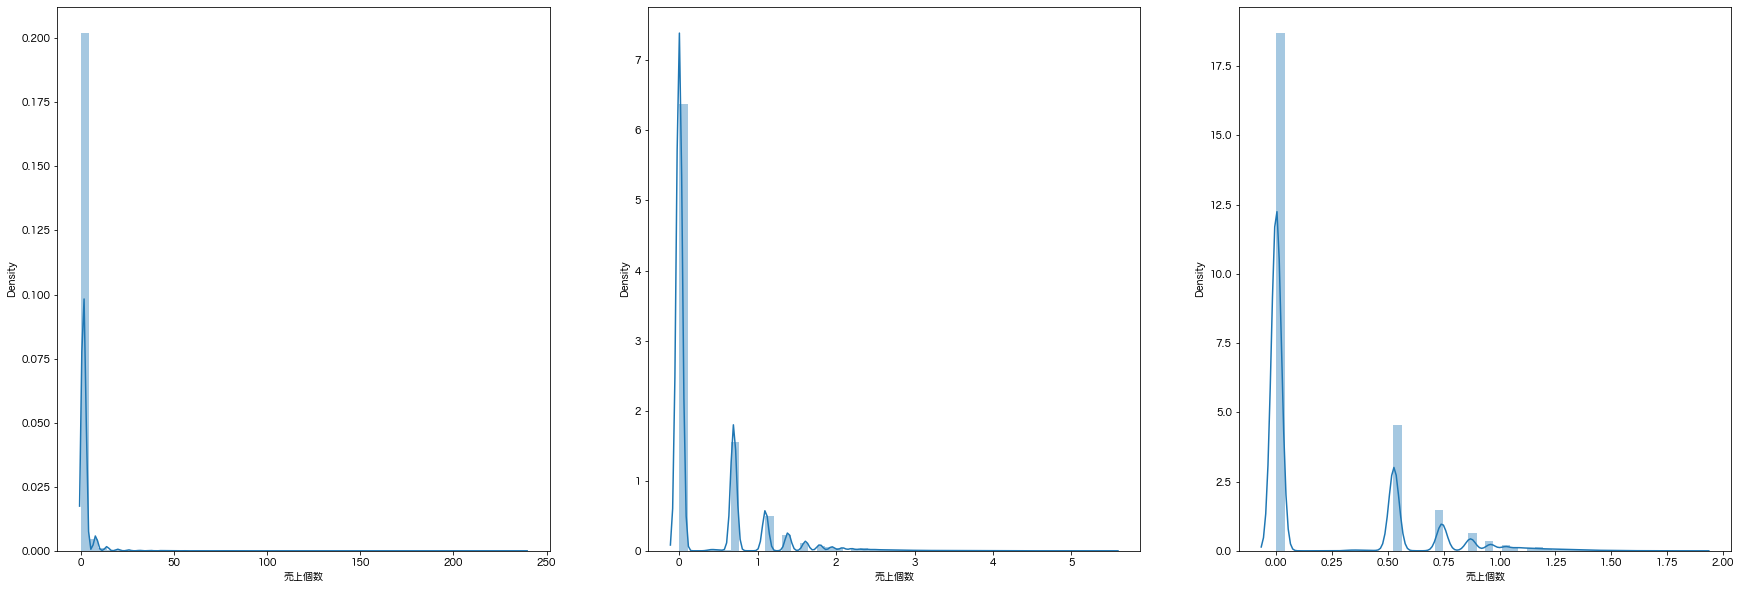

In [18]:

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[30, 10])

sns.distplot(y_data[y_data.notnull()], ax=ax1)
#歪度と尖度を計算
print('y_train')
print("歪度: %f" % y_data.skew())
print("尖度: %f" % y_data.kurt())

print('=============')
y_data_log1p = np.log1p(y_data[y_data.notnull()])
sns.distplot(y_data_log1p, ax=ax2)
print('np.exp(train_y_log)')
#歪度と尖度を計算
print("歪度: %f" % y_data_log1p.skew())
print("尖度: %f" % y_data_log1p.kurt())

print('=============')
y_data_log1p_log1p = np.log1p(y_data_log1p)
sns.distplot(y_data_log1p_log1p, ax=ax3)
print('np.exp(train_y_log)')
#歪度と尖度を計算
print("歪度: %f" % y_data_log1p_log1p.skew())
print("尖度: %f" % y_data_log1p_log1p.kurt())

# パラメータチューニング¶

In [19]:
X_trainval

月ブロック  商品ID  year  month  holiday_cnt  month_cos     month_sin  \
904788      11     0  2018     12            2   1.000000 -2.449294e-16   
904789      11     1  2018     12            2   1.000000 -2.449294e-16   
904790      11     2  2018     12            2   1.000000 -2.449294e-16   
904791      11     3  2018     12            2   1.000000 -2.449294e-16   
904792      11     4  2018     12            2   1.000000 -2.449294e-16   
...        ...   ...   ...    ...          ...        ...           ...   
1651567     22  6883  2019     11            3   0.866025 -5.000000e-01   
1651568     22  6883  2019     11            3   0.866025 -5.000000e-01   
1651569     22  6883  2019     11            3   0.866025 -5.000000e-01   
1651570     22  6883  2019     11            3   0.866025 -5.000000e-01   
1651571     22  6883  2019     11            3   0.866025 -5.000000e-01   

        商品カテゴリ名  カテゴリ内_商品数  カテゴリtype1内_商品数  カテゴリtype2内_商品数  カテゴリtype3内_商品数  \
904788       16       2733            4186            2733             NaN   
904789       16       2733            4186            2733             NaN   
904790       16       2733            4186            2733             NaN   
904791       16       2733            4186            2733             NaN   
904792       16       2733            4186            2733             NaN   
...         ...        ...             ...             ...             ...   
1651567      21         76             445             357           165.0   
1651568      21         76             445             357           165.0   
1651569      21         76             445             357           165.0   
1651570      21         76             445             357           165.0   
1651571      21         76             445             357           165.0   

         商品カテゴリ名_contains_ゲーム  商品カテゴリ名_contains_PC  商品価格_leak_sum_lag_1  \
904788                      0                    0                840.0   
904789                      0                    0                  NaN   
904790                      0                    0                  NaN   
904791                      0                    0                  NaN   
904792                      0                    0                250.0   
...                       ...                  ...                  ...   
1651567                     0                    0                840.0   
1651568                     0                    0                  NaN   
1651569                     0                    0                  NaN   
1651570                     0                    0                  NaN   
1651571                     0                    0                  NaN   

         商品価格_leak_sum_lag_2  商品価格_leak_sum_lag_3  商品価格_leak_sum_lag_4  \
904788                   NaN                420.0                840.0   
904789                 250.0                500.0                  NaN   
904790                   NaN                250.0                  NaN   
904791                   NaN                  NaN                  NaN   
904792                 500.0                  NaN                500.0   
...                      ...                  ...                  ...   
1651567               1260.0                420.0                420.0   
1651568                  NaN                  NaN                  NaN   
1651569                  NaN                  NaN                  NaN   
1651570                  NaN                  NaN                  NaN   
1651571                  NaN                  NaN                  NaN   

         商品価格_leak_sum_lag_5  商品価格_leak_sum_lag_6  商品価格_leak_sum_lag_7  \
904788                1260.0               1680.0                  NaN   
904789                 250.0                  NaN                500.0   
904790                 250.0                  NaN                  NaN   
904791                   NaN                  NaN                500.0   
904792     

In [20]:
y_trainval

904788     0.000000
904789     0.000000
904790     2.000000
904791     0.000000
904792     1.000000
             ...   
1651567    0.844929
1651568    0.437225
1651569    0.455269
1651570    0.447218
1651571    0.470590
Name: 売上個数, Length: 746784, dtype: float64

In [21]:
# 学習データとしては、「12ヶ月前の売上個数」カラムが存在するレコードのみを抽出する
X_train = X_trainval[(X_trainval.月ブロック >= 11) & (X_trainval.月ブロック <= 21)]
y_train = y_trainval[(X_trainval.月ブロック>= 11) & (X_trainval.月ブロック<= 21)]

X_valid = X_trainval[X_trainval.月ブロック == 22] #11月
y_valid = y_trainval[X_trainval.月ブロック == 22]

In [22]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(743724, 1000)
(743724,)
(3060, 1000)
(3060,)


In [23]:
import optuna.integration.lightgbm as op_lgb
from sklearn import datasets, model_selection

dtrain_tuning = op_lgb.Dataset(X_train.values, label=y_train.values)
dval_tuning = op_lgb.Dataset(X_valid.values, label=y_valid.values)

In [24]:
best_params, tuning_history = dict(), list()
# ハイパーパラメータサーチ&モデル構築(回帰モデル用)
tuning_params = {'objective': 'regression',
          'metric': 'rmse',
          'num_boost_round': 5000, # 最大試行数
          'random_seed':100,
         'learning_rate': 0.01, # 学習率
         }

booster = op_lgb.train(tuning_params, 
                       dtrain_tuning, 
                       valid_sets=[dtrain_tuning, dval_tuning],
                       verbose_eval=1000,
                       early_stopping_rounds=3,)


[I 2021-10-07 00:12:49,337] A new study created in memory with name: no-name-0f87eab2-8133-4b78-9981-754770258dcc
feature_fraction, val_score: inf:   0%|                   | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.332800 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 146640
[LightGBM] [Info] Number of data points in the train set: 743724, number of used features: 997
[LightGBM] [Info] Start training from score 0.766351
Training until validation scores don't improve for 3 rounds


feature_fraction, val_score: 0.349231:  14%|8     | 1/7 [00:45<04:29, 44.96s/it]

Early stopping, best iteration is:
[59]	valid_0's rmse: 2.16305	valid_1's rmse: 0.349231
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.265585 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 146640
[LightGBM] [Info] Number of data points in the train set: 743724, number of used features: 997
[LightGBM] [Info] Start training from score 0.766351
Training until validation scores don't improve for 3 rounds


feature_fraction, val_score: 0.344320:  29%|#7    | 2/7 [01:30<03:46, 45.40s/it]

Early stopping, best iteration is:
[59]	valid_0's rmse: 2.17031	valid_1's rmse: 0.34432
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.582897 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 146640
[LightGBM] [Info] Number of data points in the train set: 743724, number of used features: 997
[LightGBM] [Info] Start training from score 0.766351
Training until validation scores don't improve for 3 rounds


feature_fraction, val_score: 0.344320:  43%|##5   | 3/7 [02:05<02:42, 40.68s/it]

Early stopping, best iteration is:
[48]	valid_0's rmse: 2.22119	valid_1's rmse: 0.416439
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.533424 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 146640
[LightGBM] [Info] Number of data points in the train set: 743724, number of used features: 997
[LightGBM] [Info] Start training from score 0.766351
Training until validation scores don't improve for 3 rounds


feature_fraction, val_score: 0.344320:  57%|###4  | 4/7 [02:41<01:56, 38.76s/it]

Early stopping, best iteration is:
[52]	valid_0's rmse: 2.19776	valid_1's rmse: 0.382847
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.503418 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 146640
[LightGBM] [Info] Number of data points in the train set: 743724, number of used features: 997
[LightGBM] [Info] Start training from score 0.766351
Training until validation scores don't improve for 3 rounds


feature_fraction, val_score: 0.344320:  71%|####2 | 5/7 [03:17<01:15, 37.69s/it]

Early stopping, best iteration is:
[47]	valid_0's rmse: 2.22868	valid_1's rmse: 0.40648
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.420569 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 146640
[LightGBM] [Info] Number of data points in the train set: 743724, number of used features: 997
[LightGBM] [Info] Start training from score 0.766351
Training until validation scores don't improve for 3 rounds


feature_fraction, val_score: 0.344320:  86%|#####1| 6/7 [03:57<00:38, 38.63s/it]

Early stopping, best iteration is:
[55]	valid_0's rmse: 2.18282	valid_1's rmse: 0.383119
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.532693 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 146640
[LightGBM] [Info] Number of data points in the train set: 743724, number of used features: 997
[LightGBM] [Info] Start training from score 0.766351
Training until validation scores don't improve for 3 rounds


feature_fraction, val_score: 0.344320: 100%|######| 7/7 [04:30<00:00, 38.71s/it]


Early stopping, best iteration is:
[47]	valid_0's rmse: 2.22816	valid_1's rmse: 0.422556


num_leaves, val_score: 0.344320:   0%|                   | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.387939 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 146640
[LightGBM] [Info] Number of data points in the train set: 743724, number of used features: 997
[LightGBM] [Info] Start training from score 0.766351
Training until validation scores don't improve for 3 rounds


num_leaves, val_score: 0.321377:   5%|5          | 1/20 [00:56<17:50, 56.35s/it]

Early stopping, best iteration is:
[56]	valid_0's rmse: 2.05507	valid_1's rmse: 0.321377
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.406504 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 146640
[LightGBM] [Info] Number of data points in the train set: 743724, number of used features: 997
[LightGBM] [Info] Start training from score 0.766351
Training until validation scores don't improve for 3 rounds


num_leaves, val_score: 0.321377:  10%|#1         | 2/20 [01:46<15:52, 52.94s/it]

Early stopping, best iteration is:
[70]	valid_0's rmse: 2.07074	valid_1's rmse: 0.322891
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.453240 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 146640
[LightGBM] [Info] Number of data points in the train set: 743724, number of used features: 997
[LightGBM] [Info] Start training from score 0.766351
Training until validation scores don't improve for 3 rounds


num_leaves, val_score: 0.321377:  15%|#6         | 3/20 [02:43<15:30, 54.74s/it]

Early stopping, best iteration is:
[59]	valid_0's rmse: 2.05118	valid_1's rmse: 0.327294
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.280110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 146640
[LightGBM] [Info] Number of data points in the train set: 743724, number of used features: 997
[LightGBM] [Info] Start training from score 0.766351
Training until validation scores don't improve for 3 rounds


num_leaves, val_score: 0.321377:  20%|##2        | 4/20 [03:31<13:53, 52.10s/it]

Early stopping, best iteration is:
[56]	valid_0's rmse: 2.06346	valid_1's rmse: 0.324215
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.317099 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 146640
[LightGBM] [Info] Number of data points in the train set: 743724, number of used features: 997
[LightGBM] [Info] Start training from score 0.766351
Training until validation scores don't improve for 3 rounds


num_leaves, val_score: 0.321377:  25%|##7        | 5/20 [04:18<12:32, 50.17s/it]

Early stopping, best iteration is:
[59]	valid_0's rmse: 2.06543	valid_1's rmse: 0.322875
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.312654 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 146640
[LightGBM] [Info] Number of data points in the train set: 743724, number of used features: 997
[LightGBM] [Info] Start training from score 0.766351
Training until validation scores don't improve for 3 rounds


num_leaves, val_score: 0.321377:  30%|###3       | 6/20 [05:05<11:26, 49.02s/it]

Early stopping, best iteration is:
[66]	valid_0's rmse: 2.08317	valid_1's rmse: 0.323881
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.313918 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 146640
[LightGBM] [Info] Number of data points in the train set: 743724, number of used features: 997
[LightGBM] [Info] Start training from score 0.766351
Training until validation scores don't improve for 3 rounds


num_leaves, val_score: 0.321377:  35%|###8       | 7/20 [05:53<10:32, 48.62s/it]

Early stopping, best iteration is:
[68]	valid_0's rmse: 2.06495	valid_1's rmse: 0.321429
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.325636 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 146640
[LightGBM] [Info] Number of data points in the train set: 743724, number of used features: 997
[LightGBM] [Info] Start training from score 0.766351
Training until validation scores don't improve for 3 rounds


num_leaves, val_score: 0.321377:  40%|####4      | 8/20 [06:39<09:33, 47.78s/it]

Early stopping, best iteration is:
[68]	valid_0's rmse: 2.09222	valid_1's rmse: 0.331603
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.286992 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 146640
[LightGBM] [Info] Number of data points in the train set: 743724, number of used features: 997
[LightGBM] [Info] Start training from score 0.766351
Training until validation scores don't improve for 3 rounds


num_leaves, val_score: 0.320835:  45%|####9      | 9/20 [07:26<08:45, 47.78s/it]

Early stopping, best iteration is:
[59]	valid_0's rmse: 2.06089	valid_1's rmse: 0.320835
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.319250 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 146640
[LightGBM] [Info] Number of data points in the train set: 743724, number of used features: 997
[LightGBM] [Info] Start training from score 0.766351
Training until validation scores don't improve for 3 rounds


num_leaves, val_score: 0.320835:  50%|#####     | 10/20 [08:15<08:01, 48.10s/it]

Early stopping, best iteration is:
[59]	valid_0's rmse: 2.05792	valid_1's rmse: 0.326198
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.295030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 146640
[LightGBM] [Info] Number of data points in the train set: 743724, number of used features: 997
[LightGBM] [Info] Start training from score 0.766351
Training until validation scores don't improve for 3 rounds


num_leaves, val_score: 0.310495:  55%|#####5    | 11/20 [09:08<07:24, 49.39s/it]

Early stopping, best iteration is:
[56]	valid_0's rmse: 2.04748	valid_1's rmse: 0.310495
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.337715 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 146640
[LightGBM] [Info] Number of data points in the train set: 743724, number of used features: 997
[LightGBM] [Info] Start training from score 0.766351
Training until validation scores don't improve for 3 rounds


num_leaves, val_score: 0.310495:  60%|######    | 12/20 [10:00<06:42, 50.34s/it]

Early stopping, best iteration is:
[56]	valid_0's rmse: 2.04731	valid_1's rmse: 0.312576
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.287355 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 146640
[LightGBM] [Info] Number of data points in the train set: 743724, number of used features: 997
[LightGBM] [Info] Start training from score 0.766351
Training until validation scores don't improve for 3 rounds


num_leaves, val_score: 0.310495:  65%|######5   | 13/20 [10:53<05:57, 51.01s/it]

Early stopping, best iteration is:
[56]	valid_0's rmse: 2.04642	valid_1's rmse: 0.313703
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.306344 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 146640
[LightGBM] [Info] Number of data points in the train set: 743724, number of used features: 997
[LightGBM] [Info] Start training from score 0.766351
Training until validation scores don't improve for 3 rounds


num_leaves, val_score: 0.310495:  70%|#######   | 14/20 [11:45<05:09, 51.55s/it]

Early stopping, best iteration is:
[56]	valid_0's rmse: 2.04642	valid_1's rmse: 0.313703
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.312611 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 146640
[LightGBM] [Info] Number of data points in the train set: 743724, number of used features: 997
[LightGBM] [Info] Start training from score 0.766351
Training until validation scores don't improve for 3 rounds


num_leaves, val_score: 0.310495:  75%|#######5  | 15/20 [12:37<04:18, 51.62s/it]

Early stopping, best iteration is:
[56]	valid_0's rmse: 2.05287	valid_1's rmse: 0.321
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.364252 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 146640
[LightGBM] [Info] Number of data points in the train set: 743724, number of used features: 997
[LightGBM] [Info] Start training from score 0.766351
Training until validation scores don't improve for 3 rounds


num_leaves, val_score: 0.310495:  80%|########  | 16/20 [13:33<03:30, 52.74s/it]

Early stopping, best iteration is:
[57]	valid_0's rmse: 2.04626	valid_1's rmse: 0.318418
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.367603 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 146640
[LightGBM] [Info] Number of data points in the train set: 743724, number of used features: 997
[LightGBM] [Info] Start training from score 0.766351
Training until validation scores don't improve for 3 rounds


num_leaves, val_score: 0.310495:  85%|########5 | 17/20 [14:29<02:41, 53.81s/it]

Early stopping, best iteration is:
[101]	valid_0's rmse: 2.27197	valid_1's rmse: 0.340005
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.339119 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 146640
[LightGBM] [Info] Number of data points in the train set: 743724, number of used features: 997
[LightGBM] [Info] Start training from score 0.766351
Training until validation scores don't improve for 3 rounds


num_leaves, val_score: 0.310495:  90%|######### | 18/20 [15:20<01:46, 53.13s/it]

Early stopping, best iteration is:
[57]	valid_0's rmse: 2.05544	valid_1's rmse: 0.320745
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.349461 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 146640
[LightGBM] [Info] Number of data points in the train set: 743724, number of used features: 997
[LightGBM] [Info] Start training from score 0.766351
Training until validation scores don't improve for 3 rounds


num_leaves, val_score: 0.310495:  95%|#########5| 19/20 [16:15<00:53, 53.68s/it]

Early stopping, best iteration is:
[59]	valid_0's rmse: 2.02486	valid_1's rmse: 0.314119
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.342478 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 146640
[LightGBM] [Info] Number of data points in the train set: 743724, number of used features: 997
[LightGBM] [Info] Start training from score 0.766351
Training until validation scores don't improve for 3 rounds


num_leaves, val_score: 0.310495: 100%|##########| 20/20 [17:05<00:00, 51.27s/it]


Early stopping, best iteration is:
[59]	valid_0's rmse: 2.08389	valid_1's rmse: 0.323934


bagging, val_score: 0.310495:   0%|                      | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.326525 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 146640
[LightGBM] [Info] Number of data points in the train set: 743724, number of used features: 997
[LightGBM] [Info] Start training from score 0.766351
Training until validation scores don't improve for 3 rounds


bagging, val_score: 0.283287:  10%|#4            | 1/10 [00:56<08:32, 56.91s/it]

Early stopping, best iteration is:
[65]	valid_0's rmse: 1.98768	valid_1's rmse: 0.283287
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.496009 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 146640
[LightGBM] [Info] Number of data points in the train set: 743724, number of used features: 997
[LightGBM] [Info] Start training from score 0.766351
Training until validation scores don't improve for 3 rounds


bagging, val_score: 0.283287:  20%|##8           | 2/10 [01:47<07:07, 53.42s/it]

Early stopping, best iteration is:
[56]	valid_0's rmse: 2.08746	valid_1's rmse: 0.301613
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.343113 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 146640
[LightGBM] [Info] Number of data points in the train set: 743724, number of used features: 997
[LightGBM] [Info] Start training from score 0.766351
Training until validation scores don't improve for 3 rounds


bagging, val_score: 0.283287:  30%|####2         | 3/10 [02:39<06:09, 52.77s/it]

Early stopping, best iteration is:
[57]	valid_0's rmse: 2.06899	valid_1's rmse: 0.293591
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.311797 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 146640
[LightGBM] [Info] Number of data points in the train set: 743724, number of used features: 997
[LightGBM] [Info] Start training from score 0.766351
Training until validation scores don't improve for 3 rounds


bagging, val_score: 0.283287:  40%|#####6        | 4/10 [03:36<05:26, 54.42s/it]

Early stopping, best iteration is:
[64]	valid_0's rmse: 1.99755	valid_1's rmse: 0.296891
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.351279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 146640
[LightGBM] [Info] Number of data points in the train set: 743724, number of used features: 997
[LightGBM] [Info] Start training from score 0.766351
Training until validation scores don't improve for 3 rounds


bagging, val_score: 0.283287:  50%|#######       | 5/10 [04:31<04:32, 54.47s/it]

Early stopping, best iteration is:
[59]	valid_0's rmse: 2.03754	valid_1's rmse: 0.301642
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.302607 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 146640
[LightGBM] [Info] Number of data points in the train set: 743724, number of used features: 997
[LightGBM] [Info] Start training from score 0.766351
Training until validation scores don't improve for 3 rounds


bagging, val_score: 0.279929:  60%|########4     | 6/10 [05:26<03:38, 54.67s/it]

Early stopping, best iteration is:
[64]	valid_0's rmse: 2.0217	valid_1's rmse: 0.279929
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.338496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 146640
[LightGBM] [Info] Number of data points in the train set: 743724, number of used features: 997
[LightGBM] [Info] Start training from score 0.766351
Training until validation scores don't improve for 3 rounds


bagging, val_score: 0.279929:  70%|#########7    | 7/10 [06:21<02:44, 54.79s/it]

Early stopping, best iteration is:
[59]	valid_0's rmse: 2.03117	valid_1's rmse: 0.307105
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.330337 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 146640
[LightGBM] [Info] Number of data points in the train set: 743724, number of used features: 997
[LightGBM] [Info] Start training from score 0.766351
Training until validation scores don't improve for 3 rounds


bagging, val_score: 0.279929:  80%|###########2  | 8/10 [07:12<01:46, 53.47s/it]

Early stopping, best iteration is:
[56]	valid_0's rmse: 2.08786	valid_1's rmse: 0.292821
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.332726 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 146640
[LightGBM] [Info] Number of data points in the train set: 743724, number of used features: 997
[LightGBM] [Info] Start training from score 0.766351
Training until validation scores don't improve for 3 rounds


bagging, val_score: 0.279929:  90%|############6 | 9/10 [08:05<00:53, 53.49s/it]

Early stopping, best iteration is:
[59]	valid_0's rmse: 2.03587	valid_1's rmse: 0.292724
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.349770 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 146640
[LightGBM] [Info] Number of data points in the train set: 743724, number of used features: 997
[LightGBM] [Info] Start training from score 0.766351
Training until validation scores don't improve for 3 rounds


bagging, val_score: 0.279929: 100%|#############| 10/10 [09:02<00:00, 54.24s/it]


Early stopping, best iteration is:
[66]	valid_0's rmse: 2.00624	valid_1's rmse: 0.300747


feature_fraction_stage2, val_score: 0.279929:   0%|       | 0/3 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.392096 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 146640
[LightGBM] [Info] Number of data points in the train set: 743724, number of used features: 997
[LightGBM] [Info] Start training from score 0.766351
Training until validation scores don't improve for 3 rounds


feature_fraction_stage2, val_score: 0.279929:  33%|3| 1/3 [00:55<01:50, 55.40s/i[I 2021-10-07 00:44:23,620] Trial 37 finished with value: 0.3127644183962633 and parameters: {'feature_fraction': 0.48000000000000004}. Best is trial 37 with value: 0.3127644183962633.
feature_fraction_stage2, val_score: 0.279929:  33%|3| 1/3 [00:55<01:50, 55.40s/i

Early stopping, best iteration is:
[59]	valid_0's rmse: 2.0497	valid_1's rmse: 0.312764
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.318902 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 146640
[LightGBM] [Info] Number of data points in the train set: 743724, number of used features: 997
[LightGBM] [Info] Start training from score 0.766351
Training until validation scores don't improve for 3 rounds


feature_fraction_stage2, val_score: 0.277780:  67%|6| 2/3 [01:50<00:55, 55.24s/i[I 2021-10-07 00:45:18,756] Trial 38 finished with value: 0.27778038729589644 and parameters: {'feature_fraction': 0.41600000000000004}. Best is trial 38 with value: 0.27778038729589644.
feature_fraction_stage2, val_score: 0.277780:  67%|6| 2/3 [01:50<00:55, 55.24s/i

Early stopping, best iteration is:
[64]	valid_0's rmse: 2.02071	valid_1's rmse: 0.27778
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.341915 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 146640
[LightGBM] [Info] Number of data points in the train set: 743724, number of used features: 997
[LightGBM] [Info] Start training from score 0.766351
Training until validation scores don't improve for 3 rounds


feature_fraction_stage2, val_score: 0.277780: 100%|#| 3/3 [02:44<00:00, 54.80s/i[I 2021-10-07 00:46:13,032] Trial 39 finished with value: 0.2936178896118534 and parameters: {'feature_fraction': 0.44800000000000006}. Best is trial 38 with value: 0.27778038729589644.
feature_fraction_stage2, val_score: 0.277780: 100%|#| 3/3 [02:44<00:00, 54.95s/i


Early stopping, best iteration is:
[59]	valid_0's rmse: 2.05223	valid_1's rmse: 0.293618


regularization_factors, val_score: 0.277780:   0%|       | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.351466 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 146640
[LightGBM] [Info] Number of data points in the train set: 743724, number of used features: 997
[LightGBM] [Info] Start training from score 0.766351
Training until validation scores don't improve for 3 rounds


regularization_factors, val_score: 0.277780:   5%| | 1/20 [00:56<17:52, 56.46s/i[I 2021-10-07 00:47:09,572] Trial 40 finished with value: 0.279931431293253 and parameters: {'lambda_l1': 0.010773079835495351, 'lambda_l2': 0.00035615450960854435}. Best is trial 40 with value: 0.279931431293253.
regularization_factors, val_score: 0.277780:   5%| | 1/20 [00:56<17:52, 56.46s/i

Early stopping, best iteration is:
[64]	valid_0's rmse: 2.02088	valid_1's rmse: 0.279931
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.346427 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 146640
[LightGBM] [Info] Number of data points in the train set: 743724, number of used features: 997
[LightGBM] [Info] Start training from score 0.766351
Training until validation scores don't improve for 3 rounds


regularization_factors, val_score: 0.277665:  10%|1| 2/20 [01:53<17:03, 56.86s/i[I 2021-10-07 00:48:06,698] Trial 41 finished with value: 0.2776651596231386 and parameters: {'lambda_l1': 5.596055580383097e-06, 'lambda_l2': 3.6292016983951373e-07}. Best is trial 41 with value: 0.2776651596231386.
regularization_factors, val_score: 0.277665:  10%|1| 2/20 [01:53<17:03, 56.86s/i

Early stopping, best iteration is:
[64]	valid_0's rmse: 2.02072	valid_1's rmse: 0.277665
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.354431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 146640
[LightGBM] [Info] Number of data points in the train set: 743724, number of used features: 997
[LightGBM] [Info] Start training from score 0.766351
Training until validation scores don't improve for 3 rounds


regularization_factors, val_score: 0.277665:  15%|1| 3/20 [02:53<16:32, 58.36s/i[I 2021-10-07 00:49:06,851] Trial 42 finished with value: 0.27812378400018406 and parameters: {'lambda_l1': 0.0013198047167177528, 'lambda_l2': 0.00042691341570449737}. Best is trial 41 with value: 0.2776651596231386.
regularization_factors, val_score: 0.277665:  15%|1| 3/20 [02:53<16:32, 58.36s/i

Early stopping, best iteration is:
[67]	valid_0's rmse: 2.00108	valid_1's rmse: 0.278124
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.341444 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 146640
[LightGBM] [Info] Number of data points in the train set: 743724, number of used features: 997
[LightGBM] [Info] Start training from score 0.766351
Training until validation scores don't improve for 3 rounds


regularization_factors, val_score: 0.277665:  20%|2| 4/20 [03:51<15:27, 57.95s/i[I 2021-10-07 00:50:04,164] Trial 43 finished with value: 0.27778322629294167 and parameters: {'lambda_l1': 2.9213776145783663e-05, 'lambda_l2': 0.05549019401261513}. Best is trial 41 with value: 0.2776651596231386.
regularization_factors, val_score: 0.277665:  20%|2| 4/20 [03:51<15:27, 57.95s/i

Early stopping, best iteration is:
[64]	valid_0's rmse: 2.02154	valid_1's rmse: 0.277783
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.333231 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 146640
[LightGBM] [Info] Number of data points in the train set: 743724, number of used features: 997
[LightGBM] [Info] Start training from score 0.766351
Training until validation scores don't improve for 3 rounds


regularization_factors, val_score: 0.276966:  25%|2| 5/20 [04:48<14:24, 57.61s/i[I 2021-10-07 00:51:01,183] Trial 44 finished with value: 0.2769662430725626 and parameters: {'lambda_l1': 0.0004741761560303627, 'lambda_l2': 5.049676982714866e-05}. Best is trial 44 with value: 0.2769662430725626.
regularization_factors, val_score: 0.276966:  25%|2| 5/20 [04:48<14:24, 57.61s/i

Early stopping, best iteration is:
[64]	valid_0's rmse: 2.0208	valid_1's rmse: 0.276966
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.319360 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 146640
[LightGBM] [Info] Number of data points in the train set: 743724, number of used features: 997
[LightGBM] [Info] Start training from score 0.766351
Training until validation scores don't improve for 3 rounds


regularization_factors, val_score: 0.276966:  30%|3| 6/20 [05:45<13:25, 57.53s/i[I 2021-10-07 00:51:58,546] Trial 45 finished with value: 0.2776456808115196 and parameters: {'lambda_l1': 6.690595127976853e-07, 'lambda_l2': 0.0055421785297265}. Best is trial 44 with value: 0.2769662430725626.
regularization_factors, val_score: 0.276966:  30%|3| 6/20 [05:45<13:25, 57.53s/i

Early stopping, best iteration is:
[64]	valid_0's rmse: 2.02067	valid_1's rmse: 0.277646
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.310400 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 146640
[LightGBM] [Info] Number of data points in the train set: 743724, number of used features: 997
[LightGBM] [Info] Start training from score 0.766351
Training until validation scores don't improve for 3 rounds


regularization_factors, val_score: 0.272885:  35%|3| 7/20 [06:43<12:29, 57.63s/i[I 2021-10-07 00:52:56,364] Trial 46 finished with value: 0.27288454693246583 and parameters: {'lambda_l1': 9.667162636360615, 'lambda_l2': 2.9377518662843034}. Best is trial 46 with value: 0.27288454693246583.
regularization_factors, val_score: 0.272885:  35%|3| 7/20 [06:43<12:29, 57.63s/i

Early stopping, best iteration is:
[66]	valid_0's rmse: 2.04467	valid_1's rmse: 0.272885
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.345798 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 146640
[LightGBM] [Info] Number of data points in the train set: 743724, number of used features: 997
[LightGBM] [Info] Start training from score 0.766351
Training until validation scores don't improve for 3 rounds


regularization_factors, val_score: 0.264241:  40%|4| 8/20 [07:45<11:47, 58.96s/i[I 2021-10-07 00:53:58,199] Trial 47 finished with value: 0.26424147485239075 and parameters: {'lambda_l1': 4.084458209309731, 'lambda_l2': 5.212259300079021}. Best is trial 47 with value: 0.26424147485239075.
regularization_factors, val_score: 0.264241:  40%|4| 8/20 [07:45<11:47, 58.96s/i

Early stopping, best iteration is:
[73]	valid_0's rmse: 2.01423	valid_1's rmse: 0.264241
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.346189 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 146640
[LightGBM] [Info] Number of data points in the train set: 743724, number of used features: 997
[LightGBM] [Info] Start training from score 0.766351
Training until validation scores don't improve for 3 rounds


regularization_factors, val_score: 0.264241:  45%|4| 9/20 [08:41<10:41, 58.29s/i[I 2021-10-07 00:54:55,019] Trial 48 finished with value: 0.2781858072184557 and parameters: {'lambda_l1': 0.00217823695709992, 'lambda_l2': 0.0014075362274515774}. Best is trial 47 with value: 0.26424147485239075.
regularization_factors, val_score: 0.264241:  45%|4| 9/20 [08:41<10:41, 58.29s/i

Early stopping, best iteration is:
[64]	valid_0's rmse: 2.02062	valid_1's rmse: 0.278186
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.341894 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 146640
[LightGBM] [Info] Number of data points in the train set: 743724, number of used features: 997
[LightGBM] [Info] Start training from score 0.766351
Training until validation scores don't improve for 3 rounds


regularization_factors, val_score: 0.264241:  50%|5| 10/20 [09:40<09:43, 58.38s/[I 2021-10-07 00:55:53,587] Trial 49 finished with value: 0.27681511698660827 and parameters: {'lambda_l1': 0.0009145801112355867, 'lambda_l2': 0.00654827502830435}. Best is trial 47 with value: 0.26424147485239075.
regularization_factors, val_score: 0.264241:  50%|5| 10/20 [09:40<09:43, 58.38s/

Early stopping, best iteration is:
[64]	valid_0's rmse: 2.02073	valid_1's rmse: 0.276815
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.346385 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 146640
[LightGBM] [Info] Number of data points in the train set: 743724, number of used features: 997
[LightGBM] [Info] Start training from score 0.766351
Training until validation scores don't improve for 3 rounds


regularization_factors, val_score: 0.264241:  55%|5| 11/20 [10:39<08:48, 58.69s/[I 2021-10-07 00:56:52,987] Trial 50 finished with value: 0.2656450462528948 and parameters: {'lambda_l1': 3.0797548231171534, 'lambda_l2': 2.474753225030008}. Best is trial 47 with value: 0.26424147485239075.
regularization_factors, val_score: 0.264241:  55%|5| 11/20 [10:39<08:48, 58.69s/

Early stopping, best iteration is:
[69]	valid_0's rmse: 2.01579	valid_1's rmse: 0.265645
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.355587 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 146640
[LightGBM] [Info] Number of data points in the train set: 743724, number of used features: 997
[LightGBM] [Info] Start training from score 0.766351
Training until validation scores don't improve for 3 rounds


regularization_factors, val_score: 0.264241:  60%|6| 12/20 [11:39<07:50, 58.86s/[I 2021-10-07 00:57:52,225] Trial 51 finished with value: 0.2735478301118021 and parameters: {'lambda_l1': 5.543392837904317, 'lambda_l2': 5.652372346964071}. Best is trial 47 with value: 0.26424147485239075.
regularization_factors, val_score: 0.264241:  60%|6| 12/20 [11:39<07:50, 58.86s/

Early stopping, best iteration is:
[67]	valid_0's rmse: 2.05491	valid_1's rmse: 0.273548
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.340934 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 146640
[LightGBM] [Info] Number of data points in the train set: 743724, number of used features: 997
[LightGBM] [Info] Start training from score 0.766351
Training until validation scores don't improve for 3 rounds


regularization_factors, val_score: 0.264241:  65%|6| 13/20 [12:37<06:50, 58.70s/[I 2021-10-07 00:58:50,564] Trial 52 finished with value: 0.2781447285985445 and parameters: {'lambda_l1': 0.11202676856121183, 'lambda_l2': 1.3850862146078402}. Best is trial 47 with value: 0.26424147485239075.
regularization_factors, val_score: 0.264241:  65%|6| 13/20 [12:37<06:50, 58.70s/

Early stopping, best iteration is:
[66]	valid_0's rmse: 2.02238	valid_1's rmse: 0.278145
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.321032 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 146640
[LightGBM] [Info] Number of data points in the train set: 743724, number of used features: 997
[LightGBM] [Info] Start training from score 0.766351
Training until validation scores don't improve for 3 rounds


regularization_factors, val_score: 0.264241:  70%|7| 14/20 [13:36<05:52, 58.80s/[I 2021-10-07 00:59:49,576] Trial 53 finished with value: 0.2804598168725282 and parameters: {'lambda_l1': 0.4285898239450777, 'lambda_l2': 0.15637141895857612}. Best is trial 47 with value: 0.26424147485239075.
regularization_factors, val_score: 0.264241:  70%|7| 14/20 [13:36<05:52, 58.80s/

Early stopping, best iteration is:
[67]	valid_0's rmse: 2.0039	valid_1's rmse: 0.28046
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.347954 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 146640
[LightGBM] [Info] Number of data points in the train set: 743724, number of used features: 997
[LightGBM] [Info] Start training from score 0.766351
Training until validation scores don't improve for 3 rounds


regularization_factors, val_score: 0.264241:  75%|7| 15/20 [14:41<05:02, 60.57s/[I 2021-10-07 01:00:54,263] Trial 54 finished with value: 0.2673464149524881 and parameters: {'lambda_l1': 1.2451732045631245e-08, 'lambda_l2': 8.451220746298036}. Best is trial 47 with value: 0.26424147485239075.
regularization_factors, val_score: 0.264241:  75%|7| 15/20 [14:41<05:02, 60.57s/

Early stopping, best iteration is:
[78]	valid_0's rmse: 2.00242	valid_1's rmse: 0.267346
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.363149 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 146640
[LightGBM] [Info] Number of data points in the train set: 743724, number of used features: 997
[LightGBM] [Info] Start training from score 0.766351
Training until validation scores don't improve for 3 rounds


regularization_factors, val_score: 0.264241:  80%|8| 16/20 [15:38<03:58, 59.74s/[I 2021-10-07 01:01:52,082] Trial 55 finished with value: 0.27992648152211164 and parameters: {'lambda_l1': 0.5986372383724305, 'lambda_l2': 2.2686896852659043e-08}. Best is trial 47 with value: 0.26424147485239075.
regularization_factors, val_score: 0.264241:  80%|8| 16/20 [15:39<03:58, 59.74s/

Early stopping, best iteration is:
[64]	valid_0's rmse: 2.02215	valid_1's rmse: 0.279926
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.337639 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 146640
[LightGBM] [Info] Number of data points in the train set: 743724, number of used features: 997
[LightGBM] [Info] Start training from score 0.766351
Training until validation scores don't improve for 3 rounds


regularization_factors, val_score: 0.264241:  85%|8| 17/20 [16:36<02:57, 59.21s/[I 2021-10-07 01:02:50,059] Trial 56 finished with value: 0.28422857292145026 and parameters: {'lambda_l1': 9.83827200474926, 'lambda_l2': 0.3068177834871441}. Best is trial 47 with value: 0.26424147485239075.
regularization_factors, val_score: 0.264241:  85%|8| 17/20 [16:37<02:57, 59.21s/

Early stopping, best iteration is:
[65]	valid_0's rmse: 2.0268	valid_1's rmse: 0.284229
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.352223 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 146640
[LightGBM] [Info] Number of data points in the train set: 743724, number of used features: 997
[LightGBM] [Info] Start training from score 0.766351
Training until validation scores don't improve for 3 rounds


regularization_factors, val_score: 0.264241:  90%|9| 18/20 [17:35<01:58, 59.13s/[I 2021-10-07 01:03:49,017] Trial 57 finished with value: 0.27701418875585765 and parameters: {'lambda_l1': 0.04137417056847017, 'lambda_l2': 2.4402287712428122e-05}. Best is trial 47 with value: 0.26424147485239075.
regularization_factors, val_score: 0.264241:  90%|9| 18/20 [17:35<01:58, 59.13s/

Early stopping, best iteration is:
[64]	valid_0's rmse: 2.02108	valid_1's rmse: 0.277014
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.323410 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 146640
[LightGBM] [Info] Number of data points in the train set: 743724, number of used features: 997
[LightGBM] [Info] Start training from score 0.766351
Training until validation scores don't improve for 3 rounds


regularization_factors, val_score: 0.264241:  95%|9| 19/20 [18:34<00:58, 58.83s/[I 2021-10-07 01:04:47,142] Trial 58 finished with value: 0.2771308599848025 and parameters: {'lambda_l1': 1.2223694409690422, 'lambda_l2': 0.06233151436333218}. Best is trial 47 with value: 0.26424147485239075.
regularization_factors, val_score: 0.264241:  95%|9| 19/20 [18:34<00:58, 58.83s/

Early stopping, best iteration is:
[64]	valid_0's rmse: 2.02339	valid_1's rmse: 0.277131
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.348767 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 146640
[LightGBM] [Info] Number of data points in the train set: 743724, number of used features: 997
[LightGBM] [Info] Start training from score 0.766351
Training until validation scores don't improve for 3 rounds


regularization_factors, val_score: 0.264241: 100%|#| 20/20 [19:35<00:00, 59.71s/[I 2021-10-07 01:05:48,938] Trial 59 finished with value: 0.2732665005160491 and parameters: {'lambda_l1': 0.04119151954077078, 'lambda_l2': 0.8840453323440933}. Best is trial 47 with value: 0.26424147485239075.
regularization_factors, val_score: 0.264241: 100%|#| 20/20 [19:35<00:00, 58.80s/


Early stopping, best iteration is:
[64]	valid_0's rmse: 2.03038	valid_1's rmse: 0.273267


min_data_in_leaf, val_score: 0.264241:   0%|              | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.357292 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 146640
[LightGBM] [Info] Number of data points in the train set: 743724, number of used features: 997
[LightGBM] [Info] Start training from score 0.766351
Training until validation scores don't improve for 3 rounds


min_data_in_leaf, val_score: 0.264241:  20%|#2    | 1/5 [01:00<04:01, 60.38s/it]

Early stopping, best iteration is:
[66]	valid_0's rmse: 2.11071	valid_1's rmse: 0.274741
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.324588 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 146640
[LightGBM] [Info] Number of data points in the train set: 743724, number of used features: 997
[LightGBM] [Info] Start training from score 0.766351
Training until validation scores don't improve for 3 rounds


min_data_in_leaf, val_score: 0.264241:  40%|##4   | 2/5 [01:59<02:58, 59.63s/it]

Early stopping, best iteration is:
[66]	valid_0's rmse: 2.06191	valid_1's rmse: 0.283088
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.362319 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 146640
[LightGBM] [Info] Number of data points in the train set: 743724, number of used features: 997
[LightGBM] [Info] Start training from score 0.766351
Training until validation scores don't improve for 3 rounds


min_data_in_leaf, val_score: 0.264241:  60%|###6  | 3/5 [02:58<01:58, 59.13s/it]

Early stopping, best iteration is:
[64]	valid_0's rmse: 2.09318	valid_1's rmse: 0.30815
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.349337 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 146640
[LightGBM] [Info] Number of data points in the train set: 743724, number of used features: 997
[LightGBM] [Info] Start training from score 0.766351
Training until validation scores don't improve for 3 rounds


min_data_in_leaf, val_score: 0.264241:  80%|####8 | 4/5 [04:01<01:00, 60.75s/it]

Early stopping, best iteration is:
[73]	valid_0's rmse: 2.00299	valid_1's rmse: 0.272521
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.348405 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 146640
[LightGBM] [Info] Number of data points in the train set: 743724, number of used features: 997
[LightGBM] [Info] Start training from score 0.766351
Training until validation scores don't improve for 3 rounds


min_data_in_leaf, val_score: 0.264241: 100%|######| 5/5 [05:00<00:00, 60.17s/it]

Early stopping, best iteration is:
[67]	valid_0's rmse: 2.03553	valid_1's rmse: 0.288632


In [25]:
best_params = booster.params
print(best_params)

{'objective': 'regression', 'metric': 'rmse', 'random_seed': 100, 'learning_rate': 0.01, 'feature_pre_filter': False, 'lambda_l1': 4.084458209309731, 'lambda_l2': 5.212259300079021, 'num_leaves': 252, 'feature_fraction': 0.41600000000000004, 'bagging_fraction': 0.5028173458974907, 'bagging_freq': 4, 'min_child_samples': 20, 'num_iterations': 5000, 'early_stopping_round': 3}


# モデリング

In [26]:
import sys
from calendar import month_name

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


class MovingWindowKFold(TimeSeriesSplit):
    """時系列情報が含まれるカラムでソートした iloc を返す KFold"""

    def __init__(self, ts_column, clipping=False, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # 時系列データのカラムの名前
        self.ts_column = ts_column
        # 得られる添字のリストの長さを過去最小の Fold に揃えるフラグ
        self.clipping = clipping

    def split(self, X, *args, **kwargs):
        # 渡されるデータは DataFrame を仮定する
        assert isinstance(X, pd.DataFrame)

        # clipping が有効なときの長さの初期値
        train_fold_min_len, test_fold_min_len = sys.maxsize, sys.maxsize

        # 時系列のカラムを取り出す
        ts = X[self.ts_column]
        # 元々のインデックスを振り直して iloc として使える値 (0, 1, 2...) にする
        ts_df = ts.reset_index()
        # 時系列でソートする
        sorted_ts_df = ts_df.sort_values(by=self.ts_column)
        # スーパークラスのメソッドで添字を計算する
        for train_index, test_index in super().split(sorted_ts_df, *args, **kwargs):
            # 添字を元々の DataFrame の iloc として使える値に変換する
            train_iloc_index = sorted_ts_df.iloc[train_index].index
            test_iloc_index = sorted_ts_df.iloc[test_index].index

            if self.clipping:
                # TimeSeriesSplit.split() で返される Fold の大きさが徐々に大きくなることを仮定している
                train_fold_min_len = min(train_fold_min_len, len(train_iloc_index))
                test_fold_min_len = min(test_fold_min_len, len(test_iloc_index))

            yield list(train_iloc_index[-train_fold_min_len:]), list(test_iloc_index[-test_fold_min_len:])

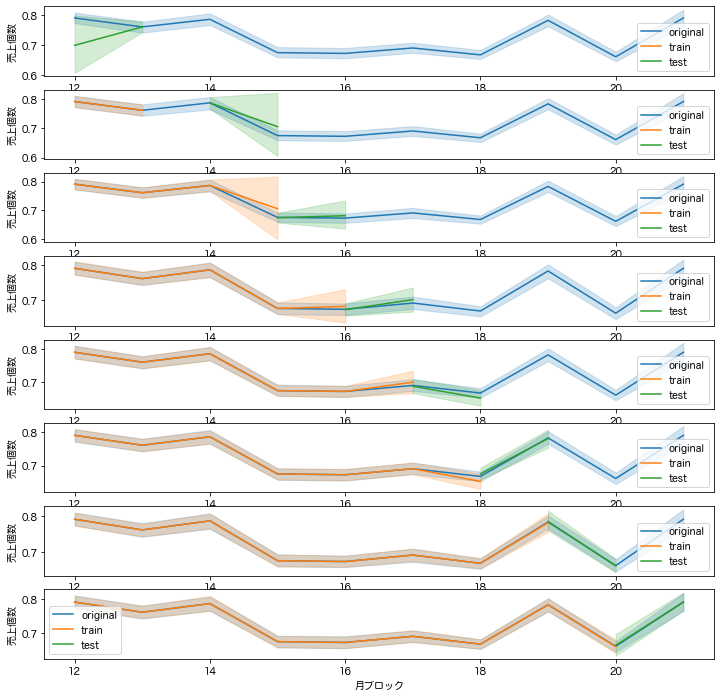

In [60]:
# df = pd.merge(X_trainval, y_trainval, right_index=True, left_index=True)

# n_splits = 8

# # データの並び順をシャッフルする
# df = df.sample(frac=1.0, random_state=42)

# # 特定のカラムを時系列としてソートした分割
# folds = MovingWindowKFold(ts_column='月ブロック', n_splits=n_splits)

# fig, axes = plt.subplots(n_splits, 1, figsize=(12, 12))

# # 元々のデータを時系列ソートした iloc が添字として得られる
# for i, (train_index, test_index) in enumerate(folds.split(df)):
#     #print(f'index of train: {train_index}')
#     #print(f'index of test: {test_index}')
#     #print('----------')
#     sns.lineplot(data=df, x='月ブロック', y='売上個数', ax=axes[i], label='original')
#     sns.lineplot(data=df.iloc[train_index], x='月ブロック', y='売上個数', ax=axes[i], label='train')
#     sns.lineplot(data=df.iloc[test_index], x='月ブロック', y='売上個数', ax=axes[i], label='test')

# plt.legend()
# plt.show()

In [27]:
from contextlib import contextmanager
from time import time

@contextmanager
def timer(logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None):
    if prefix: format_str = str(prefix) + format_str
    if suffix: format_str = format_str + str(suffix)
    start = time()
    yield
    d = time() - start
    out_str = format_str.format(d)
    if logger:
        logger.info(out_str)
    else:
        print(out_str)

In [28]:
import lightgbm as lgbm

from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error

def fit_lgbm(X, 
             y, 
             n_splits,
             params: dict=None, 
             verbose: int=50):
    
    df = pd.merge(X, y, right_index=True, left_index=True)
    # データの並び順をシャッフルする
    df = df.sample(frac=1.0, random_state=42)
    # 特定のカラムを時系列としてソートした分割
    folds = MovingWindowKFold(ts_column='月ブロック', n_splits=n_splits)
    
    
    """lightGBM を CrossValidation の枠組みで学習を行なう function"""
    metric_func = mean_squared_error

    # パラメータがないときは、空の dict で置き換える
    if params is None:
        params = {}

    models = []
    # training data の target と同じだけのゼロ配列を用意
    # float にしないと悲しい事件が起こるのでそこだけ注意
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (idx_train, idx_valid) in enumerate(folds.split(df)): 
        # この部分が交差検証のところです。データセットを cv instance によって分割します
        # training data を trian/valid に分割
        x_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
        x_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]
        
        lgb_train = lgb.Dataset(x_train, y_train) #(DataFrame, Series)
        lgb_valid = lgb.Dataset(x_valid, y_valid, reference=lgb_train) #(DataFrame, Series)
        
        # 学習
        evaluation_results  = {}  # to record evaluation results for plotting
        with timer(prefix='fit fold={} '.format(i + 1)):
            model = lgb.train(params, 
                      lgb_train,
                      valid_names=['train', 'valid'], 
                      valid_sets=[lgb_train, lgb_valid],
                     evals_result = evaluation_results,
                    verbose_eval=verbose)
            
        pred_i = model.predict(x_valid, num_iteration=model.best_iteration)

        oof_pred[idx_valid] = pred_i
        models.append(model)

        print(f'Fold {i} RMSLE: {metric_func(y_valid, pred_i) ** .5:.4f}')

    score = metric_func(y, oof_pred) ** .5
    print('FINISHED | Whole RMSLE: {:.4f}'.format(score))
    return oof_pred, models

In [29]:
params = {
    # 目的関数. これの意味で最小となるようなパラメータを探します. 
    'objective': 'rmse', 

     # 学習率. 小さいほどなめらかな決定境界が作られて性能向上に繋がる場合が多いです、
    # がそれだけ木を作るため学習に時間がかかります
    'learning_rate': 0.01,

    # L2 Reguralization
    'reg_lambda': 1.,
    # こちらは L1 
    'reg_alpha': .1,

    # 木の深さ. 深い木を許容するほどより複雑な交互作用を考慮するようになります
    'max_depth': 5, 

    # 木の最大数. early_stopping という枠組みで木の数は制御されるようにしていますのでとても大きい値を指定しておきます.
    'n_estimators': 10000, 

    # 木を作る際に考慮する特徴量の割合. 1以下を指定すると特徴をランダムに欠落させます。小さくすることで, まんべんなく特徴を使うという効果があります.
    'colsample_bytree': .5, 

    # 最小分割でのデータ数. 小さいとより細かい粒度の分割方法を許容します.
    'min_child_samples': 10,

    # bagging の頻度と割合
    'subsample_freq': 3,
    'subsample': .9,

    # 特徴重要度計算のロジック(後述)
    'importance_type': 'gain', 
    'random_state': 71,
}

params_update_flag = True

if params_update_flag:    
    params.update(best_params)
    params['num_leaves'] = int(best_params['num_leaves'])
    params['min_child_samples'] = int(best_params['min_child_samples'])
    params['bagging_freq'] = int(best_params['bagging_freq'])
print(params)

{'objective': 'regression', 'learning_rate': 0.01, 'reg_lambda': 1.0, 'reg_alpha': 0.1, 'max_depth': 5, 'n_estimators': 10000, 'colsample_bytree': 0.5, 'min_child_samples': 20, 'subsample_freq': 3, 'subsample': 0.9, 'importance_type': 'gain', 'random_state': 71, 'metric': 'rmse', 'random_seed': 100, 'feature_pre_filter': False, 'lambda_l1': 4.084458209309731, 'lambda_l2': 5.212259300079021, 'num_leaves': 252, 'feature_fraction': 0.41600000000000004, 'bagging_fraction': 0.5028173458974907, 'bagging_freq': 4, 'num_iterations': 5000, 'early_stopping_round': 3}


In [30]:
y = y_trainval.copy()
y = np.log1p(y) # log + plus1 変換する

In [31]:
n_splits = 5
oof, models = fit_lgbm(X_trainval, y, n_splits, params=params)

[LightGBM] [Warning] seed is set with random_seed=100, random_state=71 will be ignored. Current value: seed=100
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=3 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l1 is set=4.084458209309731, reg_alpha=0.1 will be ignored. Current value: lambda_l1=4.084458209309731
[LightGBM] [Warning] feature_fraction is set=0.41600000000000004, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.41600000000000004
[LightGBM] [Warning] lambda_l2 is set=5.212259300079021, reg_lambda=1.0 will be ignored. Current value: lambda_l2=5.212259300079021
[LightGBM] [Warning] bagging_fraction is set=0.5028173458974907, subsample=0.9 will be ignored. Current value: bagging_fraction=0.5028173458974907
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] seed is set with random_seed=100, random_state=71 will be

## 学習の確認

In [32]:
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importance(importance_type='gain')
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(max(6, len(order) * .4), 7))
    sns.boxenplot(data=feature_importance_df, x='column', y='feature_importance', order=order, ax=ax, palette='viridis')
    ax.tick_params(axis='x', rotation=90)
    ax.grid()
    fig.tight_layout()
    return fig, ax

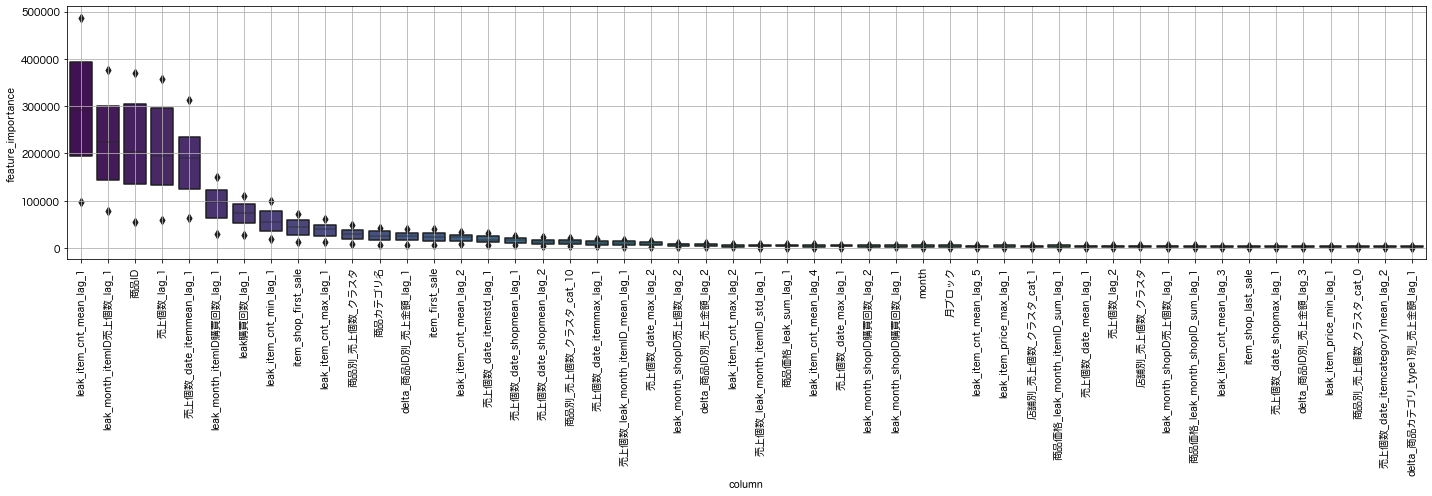

In [33]:
fig, ax = visualize_importance(models, X_trainval)

## 誤差の確認

In [34]:
comparison_df = pd.DataFrame(y_trainval).rename(columns={'売上個数': 'true'})
comparison_df['pred'] = np.expm1(oof)

comparison_df['予測との誤差'] = np.sqrt((comparison_df['true'] - comparison_df['pred'])**2)
comparison_df['index'] = comparison_df.sort_values('予測との誤差', ascending=False).reset_index().index
comparison_df

true      pred    予測との誤差   index
904788   0.000000  1.403929  1.403929       0
904789   0.000000  0.679866  0.679866       1
904790   2.000000  0.363158  1.636842       2
904791   0.000000  0.445653  0.445653       3
904792   1.000000  1.239213  0.239213       4
...           ...       ...       ...     ...
1651567  0.844929  0.947268  0.102339  746779
1651568  0.437225  0.302527  0.134698  746780
1651569  0.455269  0.235407  0.219862  746781
1651570  0.447218  0.369057  0.078161  746782
1651571  0.470590  0.000000  0.470590  746783

[746784 rows x 4 columns]

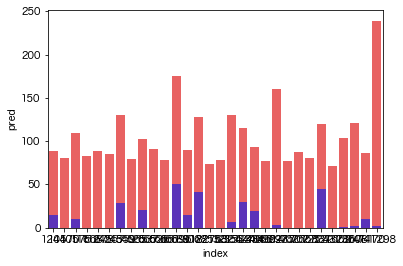

In [35]:
plt.subplot()
sns.barplot(x='index', y='true', data=comparison_df.sort_values('予測との誤差', ascending=False)[:30],color='red', alpha=0.7)
sns.barplot(x='index', y='pred', data=comparison_df.sort_values('予測との誤差', ascending=False)[:30],color='blue', alpha=0.7)
plt.show()

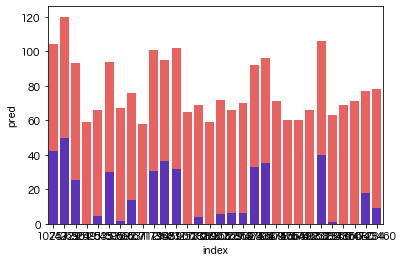

In [36]:
plt.subplot()
sns.barplot(x='index', y='true', data=comparison_df.sort_values('予測との誤差', ascending=False)[30:60],color='red', alpha=0.7)
sns.barplot(x='index', y='pred', data=comparison_df.sort_values('予測との誤差', ascending=False)[30:60],color='blue', alpha=0.7)
plt.show()

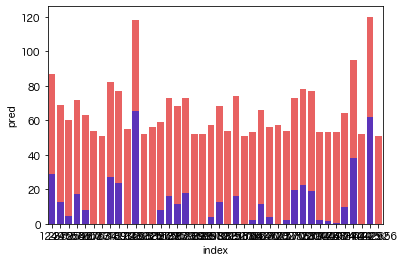

In [37]:
plt.subplot()
sns.barplot(x='index', y='true', data=comparison_df.sort_values('予測との誤差', ascending=False)[60:100],color='red', alpha=0.7)
sns.barplot(x='index', y='pred', data=comparison_df.sort_values('予測との誤差', ascending=False)[60:100],color='blue', alpha=0.7)
plt.show()

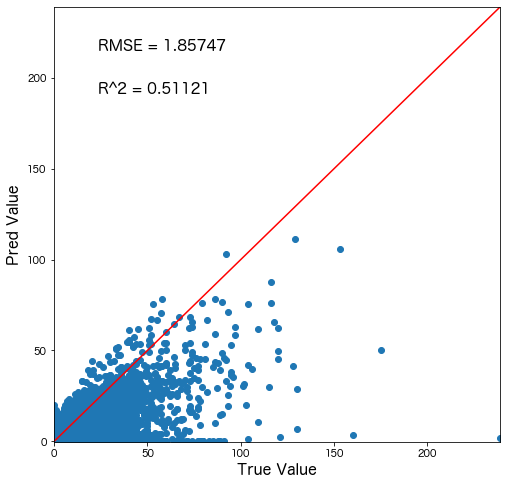

In [38]:
True_Pred_map(comparison_df[['true', 'pred']])

# 誤差の多いやつを再学習

In [45]:
# Failure_index = comparison_df[comparison_df['予測との誤差'] > 10].index
# len(Failure_index)

In [39]:
Failure_index = comparison_df.sort_values('予測との誤差', ascending=False).head(100000).sort_index().index
len(Failure_index)

100000

In [40]:
Failure_X_trainval = X_trainval.loc[Failure_index]
Failure_y = y[Failure_index]

In [41]:
params = {
    # 目的関数. これの意味で最小となるようなパラメータを探します. 
    'objective': 'rmse', 

     # 学習率. 小さいほどなめらかな決定境界が作られて性能向上に繋がる場合が多いです、
    # がそれだけ木を作るため学習に時間がかかります
    'learning_rate': 0.01,

    # L2 Reguralization
    'reg_lambda': 1.,
    # こちらは L1 
    'reg_alpha': .1,

    # 木の深さ. 深い木を許容するほどより複雑な交互作用を考慮するようになります
    'max_depth': 5, 

    # 木の最大数. early_stopping という枠組みで木の数は制御されるようにしていますのでとても大きい値を指定しておきます.
    'n_estimators': 10000, 

    # 木を作る際に考慮する特徴量の割合. 1以下を指定すると特徴をランダムに欠落させます。小さくすることで, まんべんなく特徴を使うという効果があります.
    'colsample_bytree': .5, 

    # 最小分割でのデータ数. 小さいとより細かい粒度の分割方法を許容します.
    'min_child_samples': 10,

    # bagging の頻度と割合
    'subsample_freq': 3,
    'subsample': .9,

    # 特徴重要度計算のロジック(後述)
    'importance_type': 'gain', 
    'random_state': 71,
}

params.update(best_params)
params['num_leaves'] = int(best_params['num_leaves'])
params['min_child_samples'] = int(best_params['min_child_samples'])
params['bagging_freq'] = int(best_params['bagging_freq'])
print(params)

n_splits = 5
Failure_oof, Failure_models = fit_lgbm(Failure_X_trainval, Failure_y, n_splits, params=params)

for model in Failure_models:
    models.append(model)

{'objective': 'regression', 'learning_rate': 0.01, 'reg_lambda': 1.0, 'reg_alpha': 0.1, 'max_depth': 5, 'n_estimators': 10000, 'colsample_bytree': 0.5, 'min_child_samples': 20, 'subsample_freq': 3, 'subsample': 0.9, 'importance_type': 'gain', 'random_state': 71, 'metric': 'rmse', 'random_seed': 100, 'feature_pre_filter': False, 'lambda_l1': 4.084458209309731, 'lambda_l2': 5.212259300079021, 'num_leaves': 252, 'feature_fraction': 0.41600000000000004, 'bagging_fraction': 0.5028173458974907, 'bagging_freq': 4, 'num_iterations': 5000, 'early_stopping_round': 3}
[LightGBM] [Warning] seed is set with random_seed=100, random_state=71 will be ignored. Current value: seed=100
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=3 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l1 is set=4.084458209309731, reg_alpha=0.1 will be ignored. Current value: lambda_l1=4.084458209309731
[LightGBM] [Warning] feature_

# 提出用ファイルの作成

In [42]:
models

In [69]:
def revert_to_real(y_log):
    _pred = np.expm1(y_log)
    _pred = np.where(_pred < 0, 0, _pred)
    return _pred

pred = np.array([model.predict(X_test.values) for model in models])
pred = np.mean(pred, axis=0)
pred = revert_to_real(pred)

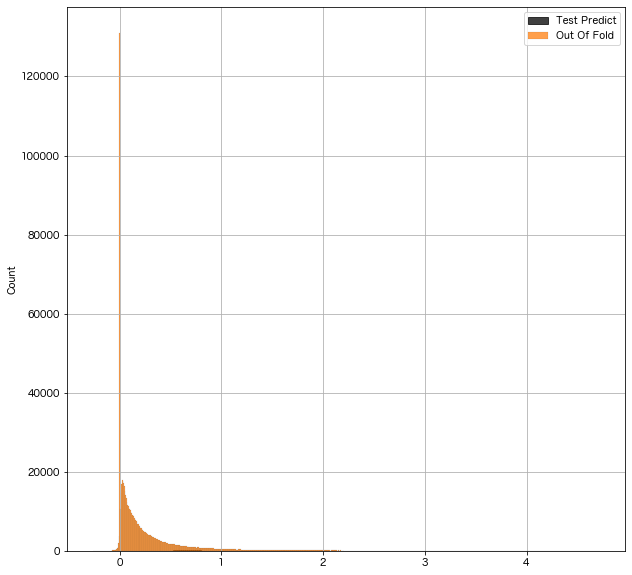

In [70]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.histplot(np.log1p(pred), label='Test Predict', ax=ax, color='black')
sns.histplot(oof, label='Out Of Fold', ax=ax, color='C1')
ax.legend()
ax.grid()

In [84]:
# sample_submissionの中身を確認
sub.head()

0    1
0  0  100
1  1  100
2  2  100
3  3  100
4  4  100

In [72]:
# sample_submissionの右側のカラムに予測値を代入する。
sub.iloc[:, -1] = pred

sub.head()

0         1
0  0  1.045412
1  1  0.825598
2  2  1.144534
3  3  1.646511
4  4  2.814048

In [68]:
# 予測ファイルの生成
sub.to_csv('./outputs/submission24_LightGBM_TimeSeriesSplit_model_adddummy11.csv', index=False, header=False)

## subの定数倍

In [78]:
sales_data = data.groupby(['year', 'month', '月ブロック'])['売上個数'].mean().reset_index()
sales_data

year  month  月ブロック      売上個数
0   2018      1      0  0.834584
1   2018      2      1  0.810969
2   2018      3      2  0.917530
3   2018      4      3  0.673059
4   2018      5      4  0.644187
5   2018      6      5  0.755337
6   2018      7      6  0.725827
7   2018      8      7  0.798923
8   2018      9      8  0.749802
9   2018     10      9  0.769051
10  2018     11     10  0.770686
11  2018     12     11  1.066117
12  2019      1     12  0.790871
13  2019      2     13  0.761160
14  2019      3     14  0.786378
15  2019      4     15  0.675469
16  2019      5     16  0.672778
17  2019      6     17  0.690604
18  2019      7     18  0.655886
19  2019      8     19  0.783080
20  2019      9     20  0.661618
21  2019     10     21  0.791243
22  2019     11     22  0.825638
23  2019     12     23       NaN

In [80]:
sales_data[sales_data.月ブロック <= 9]['売上個数'].mean()

0.7679269775596012

In [81]:
sales_data[sales_data.月ブロック == 11]['売上個数'].mean()

1.066117425596302

In [82]:
sales_data[sales_data.月ブロック == 11]['売上個数'].mean() / sales_data[sales_data.月ブロック <= 9]['売上個数'].mean()

1.3883057331627047

In [93]:
data_isin_test = data[data['商品ID'].isin(test_df['商品ID'].astype(str))]
data_isin_test[data_isin_test.月ブロック <= 9]['売上個数'].mean()

0.8069657086578924

In [86]:

# df_isin_test_2019 = df_isin_test[(df_isin_test['日付'] >= '2019-01-01') & (df_isin_test['日付'] <= '2019-10-31')]
# df_isin_test_2019_sort = df_isin_test_2019.sort_values(["日付", "店舗ID", "商品ID"])
# df_isin_test_2019_sort = df_isin_test_2019_sort.set_index('日付')
# df_isin_test_2019_group = df_isin_test_2019_sort.groupby(['商品ID', '店舗ID']).agg({"売上個数": ["sum"]})
# df_isin_test_2019_group = df_isin_test_2019_group.sort_values(['商品ID','店舗ID']).reset_index()
# df_isin_test_2019_group.columns = ["".join(c) for c in df_isin_test_2019_group.columns]
# df_isin_test_2019_group

商品ID 店舗ID  売上個数sum
0     1000001    0      6.0
1     1000001   10     11.0
2     1000001   11      8.0
3     1000001   12      7.0
4     1000001   13     20.0
...       ...  ...      ...
2698  3500001    4      5.0
2699  3500001    6      3.0
2700  3500001    7      4.0
2701  3500001    8      3.0
2702  3500001    9      2.0

[2703 rows x 3 columns]

In [89]:
sub = pd.read_csv('./inputs/sample_submission.csv', header=None)
sub

0    1
0        0  100
1        1  100
2        2  100
3        3  100
4        4  100
...    ...  ...
3055  3055  100
3056  3056  100
3057  3057  100
3058  3058  100
3059  3059  100

[3060 rows x 2 columns]

In [90]:
# sample_submissionの中身を確認
sub.head()

0    1
0  0  100
1  1  100
2  2  100
3  3  100
4  4  100

In [91]:
# sample_submissionの右側のカラムに予測値を代入する。
sub.iloc[:, -1] = pred * 1.3883057331627047

sub.head()

0         1
0  0  1.451351
1  1  1.146183
2  2  1.588963
3  3  2.285861
4  4  3.906758

In [92]:
# 予測ファイルの生成
sub.to_csv('./outputs/submission25_LightGBM_TimeSeriesSplit_model_adddummy11_1_388.csv', index=False, header=False)

# → 去年の12月と同じ * 0.77, 去年売れてないやつはモデル予測

In [49]:
test_df = pd.read_csv('./inputs/test.csv')
sales_history_addfeature_df = pd.read_pickle('./inputs/sales_history_addfeature1.pickle')

In [50]:
submit_df = test_df.copy()
submit_df = submit_df.set_index('index')
submit_df[['店舗ID', '商品ID']] = submit_df[['店舗ID', '商品ID']].astype(str)
submit_df

商品ID 店舗ID
index              
0      1000001    0
1      1000001    1
2      1000001    2
3      1000001    3
4      1000001    4
...        ...  ...
3055   3500001   13
3056   3500001   14
3057   3500001   15
3058   3500001   16
3059   3500001   17

[3060 rows x 2 columns]

### 2018年12月で絞り込み

In [51]:
df_isin_test = sales_history_addfeature_df[sales_history_addfeature_df['商品ID'].isin(test_df['商品ID'].astype(str))]
df_isin_test_201812 = df_isin_test[(df_isin_test['日付'] >= '2018-12-01') & (df_isin_test['日付'] <= '2018-12-31')]
df_isin_test_201812_sort = df_isin_test_201812.sort_values(["日付", "店舗ID", "商品ID"])
df_isin_test_201812_sort = df_isin_test_201812_sort.set_index('日付')
df_isin_test_201812_group = df_isin_test_201812_sort.groupby(['商品ID', '店舗ID']).agg({"売上個数": ["sum"]})
df_isin_test_201812_group = df_isin_test_201812_group.sort_values(['商品ID','店舗ID']).reset_index()
df_isin_test_201812_group.columns = ["".join(c) for c in df_isin_test_201812_group.columns]

In [52]:
df_isin_test_201812_group

商品ID 店舗ID  売上個数sum
0     1000001   10      3.0
1     1000001   11      2.0
2     1000001   12      2.0
3     1000001   13      4.0
4     1000001   16      1.0
...       ...  ...      ...
1777  3500001   13      3.0
1778  3500001   17      1.0
1779  3500001    2      1.0
1780  3500001    3      1.0
1781  3500001    7      1.0

[1782 rows x 3 columns]

In [53]:
#去年12月
sub = pd.merge(submit_df, df_isin_test_201812_group, on=['商品ID','店舗ID'], how='left')
sub = sub[['商品ID', '店舗ID', '売上個数sum']]
sub['売上個数sum'] = sub['売上個数sum'] * 0.7730087581405793
#モデル結果
sub['y_pred'] = pred
sub

商品ID 店舗ID   売上個数sum    y_pred
0     1000001    0       NaN  1.045412
1     1000001    1       NaN  0.825598
2     1000001    2       NaN  1.144534
3     1000001    3  6.957079  1.646511
4     1000001    4  5.411061  2.814048
...       ...  ...       ...       ...
3055  3500001   13  2.319026  1.211692
3056  3500001   14       NaN  0.682872
3057  3500001   15       NaN  0.698522
3058  3500001   16       NaN  0.687693
3059  3500001   17  0.773009  0.709183

[3060 rows x 4 columns]

In [54]:
sub['売上個数sum_addpred'] = np.where(sub['売上個数sum'].isnull(), sub['y_pred'], sub['売上個数sum'])
sub['売上個数_予測'] = sub['売上個数sum_addpred'].fillna(0)
sub

商品ID 店舗ID   売上個数sum    y_pred  売上個数sum_addpred   売上個数_予測
0     1000001    0       NaN  1.045412         1.045412  1.045412
1     1000001    1       NaN  0.825598         0.825598  0.825598
2     1000001    2       NaN  1.144534         1.144534  1.144534
3     1000001    3  6.957079  1.646511         6.957079  6.957079
4     1000001    4  5.411061  2.814048         5.411061  5.411061
...       ...  ...       ...       ...              ...       ...
3055  3500001   13  2.319026  1.211692         2.319026  2.319026
3056  3500001   14       NaN  0.682872         0.682872  0.682872
3057  3500001   15       NaN  0.698522         0.698522  0.698522
3058  3500001   16       NaN  0.687693         0.687693  0.687693
3059  3500001   17  0.773009  0.709183         0.773009  0.773009

[3060 rows x 6 columns]

In [55]:
sub['売上個数sum'].isnull().sum()

1278

In [56]:
#submit用のCSVを作成
final_sub = pd.DataFrame({"index":sub.index, "y":sub['売上個数_予測']})
print('sub["y"].isnull().sum()=', final_sub['y'].isnull().sum())
final_sub

sub["y"].isnull().sum()= 0


index         y
0         0  1.045412
1         1  0.825598
2         2  1.144534
3         3  6.957079
4         4  5.411061
...     ...       ...
3055   3055  2.319026
3056   3056  0.682872
3057   3057  0.698522
3058   3058  0.687693
3059   3059  0.773009

[3060 rows x 2 columns]

In [57]:
final_sub.to_csv('./outputs/submission23_withoutAI_addLightGBM_TimeSeriesSplit_model_adddummy11_fail.csv', header=False, index=False)